In [1]:
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
from tensorflow.keras.optimizers import Adam
from tqdm import trange
import pandas as pd
from IPython.display import clear_output
# from deadlineSchedulingEnv import deadlineSchedulingEnv
import concurrent.futures
import numpy as np

2024-03-26 12:43:59.626960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 12:43:59.626989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 12:43:59.627697: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-26 12:43:59.631953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 12:44:00.227508: W tensorflow/compiler/tf2

In [2]:
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")
print(f"TensorFlow version: {tf.__version__}")


TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.15.0


2024-03-26 12:44:00.764257: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 12:44:00.790879: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 12:44:00.791015: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
GAMMA = 0.99
LEARNING_RATE = 1e-5

MEMORY_SIZE = 1000
BATCH_SIZE = 32

EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.99992

In [4]:
state_dim=2
action_dim=2
intermediate_dim=16
T=13
B=10
processing_cost=0.8
num_states=T*B

In [5]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(1,state_dim)))
        model.add(Dense(512,activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(self.output_dim, activation = 'linear'))
        # model.compile(optimizer = RMSprop(learning_rate = self.lr, rho = 0.95, epsilon = 1e-7), loss = "mse", metrics = ['accuracy'])
        model.compile(optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=self.lr), loss = "mse", metrics = ['accuracy'])
        return model

In [6]:
class DQNSolver:
    def __init__(self, all_states,state_space,action_space, decay_coe = 0.99, 
                  memory_size = MEMORY_SIZE,EXPLORATION_DECAY=EXPLORATION_DECAY,LEARNING_RATE=LEARNING_RATE,EPSILON_MAX=EPSILON_MAX,EPSILON_MIN=EPSILON_MIN,BATCH_SIZE=BATCH_SIZE):
    
        self.all_states=all_states
        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        self.exploration_decay=EXPLORATION_DECAY
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel((1,self.states), self.n_actions, self.lr)
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
        
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        # if self.epsilon>self.min_eps:
        self.epsilon*=self.exploration_decay
        # else:
        #     self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done,subsidy):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done,subsidy])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            states.reshape(1,1,self.states)
#             states=[states]
#             states=np.array(states)
            #print(states.shape)
            action = np.argmax(np.array(self.model.Qpolicy.predict_on_batch(states)))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
    

        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            s=s.reshape(BATCH_SIZE,1,state_dim)
            #print(s.shape)
            qvalue = np.array(self.model.Qpolicy.predict_on_batch(s))
            #print(qvalue)

            s_ = self.state_shape([row[3] for row in SARS])
            s_=s_.reshape(BATCH_SIZE,1,state_dim)
            future_qvalue = np.array(self.model.Qtarget.predict_on_batch(s_))
            #print(future_qvalue)

            for index, (state, action, reward, state_, done,subsidy) in enumerate(SARS):
                if done == True:
                    Qtarget = reward +(1-action)*(subsidy)
                else:
                    Qtarget = reward +(1-action)*(subsidy) + np.max(future_qvalue[index][0])-np.array(self.model.Qpolicy.predict_on_batch((self.state_shape(self.all_states)).reshape(len(self.all_states),1,state_dim))).sum()/(len(self.all_states)*action_dim)
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget 
                #print(qcurr)
                X.append(state)
                y.append(qcurr)
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
            
            loss = self.model.Qpolicy.train_on_batch(X, y,return_dict=True)
            


                
  

In [7]:
action_space=[0,1]
state_space=np.array([[[i,j] for j in range(B)] for i in range(T)]).reshape(T*B,2)
newArrival_state_space=np.array([[[i,j] for j in range(B)] for i in range(1,T)]).reshape((T-1)*B,2)
x=list(newArrival_state_space)
x.append(np.array([0,0]))
newArrival_state_space=np.array(x)
N=5
M=2
epsilon=1
subsidy=0
arm_indexes=[i for i in range(N)]
gamma=0.9995

In [8]:
x=list(newArrival_state_space)

In [9]:
x[0]

array([1, 0])

In [10]:
np.array([0,0])

array([0, 0])

In [11]:
# env = deadlineSchedulingEnv(seed = 50, numEpisodes = 6, episodeLimit = 20, maxDeadline = 12,
# maxLoad=9, newJobProb=0.7, train=False, processingCost = 0.8, batchSize = 1, noiseVar = 0.0)


In [12]:
state_space.shape

(130, 2)

In [13]:
def newArrival(newArrival_state_space):
    return np.array(random.sample(list(newArrival_state_space), 1), dtype=np.float32).reshape(2,)


In [14]:
def step(state, action,state_space,newArrival_state_space,processing_cost=0.8):
        ''' function to calculate the reward and next state. '''
        currentState = state

        if action == 1:
            if (currentState[1] == 0) and (currentState[0] == 0): 
                reward = 0 
                nextState = newArrival(newArrival_state_space)
            elif (currentState[1] >= 0) and (currentState[0] > 1): 
                reward = (1 - processing_cost)
                currentState[0] -= 1
                currentState[1] -= 1
                if currentState[1] < 0:
                    currentState[1] = 0
                    reward = 0
                nextState = np.array([currentState[0], currentState[1]], dtype=np.float32)
            elif (currentState[1] >= 0) and (currentState[0] == 1): 
                reward = ((1 - processing_cost) - 0.2*(((currentState[1]) - 1)**2)) 
                if (currentState[1] == 0):
                    reward = 0
                currentState[1] = 0
                currentState[0] = 0
                nextState = newArrival(newArrival_state_space)

        elif action == 0:
            if (currentState[1] >= 0)  and (currentState[0] == 0):
                reward = 0
                nextState = newArrival(newArrival_state_space)
            elif (currentState[1] >= 0) and (currentState[0] > 1): 
                reward = 0
                currentState[0] -= 1
                nextState = np.array([currentState[0], currentState[1]], dtype=np.float32)
            elif (currentState[1] >= 0) and (currentState[0] == 1):  
                reward =  -0.2*(((currentState[1]))**2)  
                currentState[1] = 0
                currentState[0] = 0
                nextState = newArrival(newArrival_state_space)

        
        return nextState, reward 

In [15]:
# state=newArrival(state_space)
# print(state)
# nextState, reward=step(state,1,0.8)
# print(nextState)
# print(reward)

In [16]:
nextState, reward=step(np.array([1,3]),1,state_space,newArrival_state_space,0.8)
print(nextState)
print(reward)

[12.  2.]
-0.6000000000000001


In [17]:
dqn_solver=DQNSolver(all_states=state_space,state_space=state_dim,action_space=action_dim)



2024-03-26 12:44:00.896594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 12:44:00.896725: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 12:44:00.896810: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [18]:
current_state=[newArrival(newArrival_state_space) for _ in range(N)]
rewards=[]
subsidies=[]
action_sums=[]
betas=[]
alphas=[]
epsilon=1

In [19]:
def for_each_arm(x):
    current_state=x[0]
    dqn_solver=x[1]
    subsidy=x[2]
    state_space=np.array([[[i,j] for j in range(B)] for i in range(T)]).reshape(T*B,2)
    newArrival_state_space=np.array([[[i,j] for j in range(B)] for i in range(1,T)]).reshape((T-1)*B,2)
    x=list(newArrival_state_space)
    x.append(np.array([0,0]))
    newArrival_state_space=np.array(x)
    s=np.reshape(current_state,(1,state_dim))
    action=dqn_solver.act(s)
    x=step(current_state,action,state_space,newArrival_state_space,processing_cost=0.8)
    new_state=x[0]
    s_=np.reshape(new_state,(1,2))
    reward=x[1]
    dqn_solver.remember(s, action, reward, s_, False,subsidy)
    dqn_solver.train()
    return action,current_state

In [20]:
for i in range(1,150001):
    action_sum=0
    reward_sum=0
    beta=1/(1+np.ceil(i*np.log(i)/5000))
    
    all=[]
    for j in range(len(current_state)):
        all.append([current_state[j],dqn_solver,subsidy])


    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        futures=[executor.submit(for_each_arm,x) for x in all]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]
    
    for k,result in enumerate(results):
        action_sum+=result[0]
        current_state[k]=result[1]
    if i%100==0:
        print(i)
    dqn_solver.update_target_model()
    dqn_solver.decrement_epsilon()
    subsidy+=beta*(action_sum-M)
    subsidies.append(subsidy)
    rewards.append(reward_sum)
    action_sums.append(action_sum)
    betas.append(beta)
    clear_output(wait=True)

150000


In [21]:
dqn_solver.act([8,8])

1

In [22]:
# for i in range(1,10001):
#   # top_M_indices=act(alternative_indexes,N,M,epsilon)
#   action_sum=0
#   reward_sum=0
#   # alpha=1/(1+(i/5000))
#   beta=1/(1+np.ceil(i*np.log(i)/2000))
  
#   print(i)
#   # if(i%1000==0):
#   #    print(i)
#   for index in arm_indexes:
#       # print(index)
#       # action=np.argmax(Q_values[index][current_state[index]])
#       s=np.reshape(current_state[index],(1,state_dim))
#       action=dqn_solver.act(s)
#       action_sum+=action
#       x=step(current_state[index],action,state_space,processing_cost=0.8)
#       new_state=x[0]
#       s_=np.reshape(new_state,(1,state_dim))
#       reward=x[1]
#       dqn_solver.remember(s, action, reward, s_, False,subsidy)
#       dqn_solver.train()
#       current_state[index]=new_state
#       reward_sum+=reward
#       #print(x)
#   # print(i)
#   #print(reward_sum)
#   dqn_solver.update_target_model()
#   dqn_solver.decrement_epsilon()
#   subsidy+=beta*(action_sum-M)
#   subsidies.append(subsidy)
#   # epsilon=epsilon*gamma
#   # if epsilon<=0.01:
#   #   epsilon=0.01
#   rewards.append(reward_sum)
#   action_sums.append(action_sum)
#   betas.append(beta)
#   clear_output(wait=True)







In [23]:
dqn_solver.epsilon

6.1412636819014606e-06

In [24]:
epsilon

1

Text(0.5, 1.0, 'Subsidy vs Steps for Deadline Scehduling')

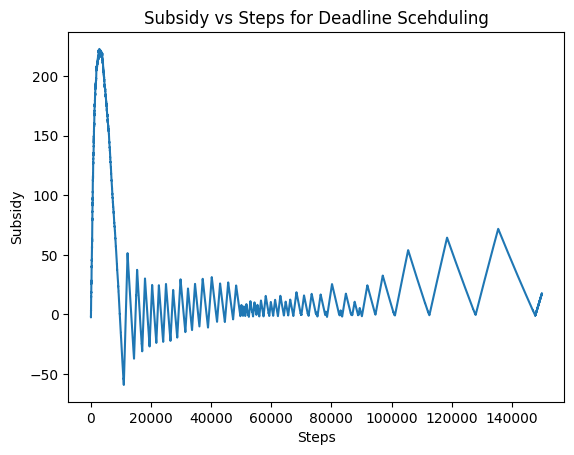

In [36]:
plt.plot(subsidies)
plt.xlabel('Steps')
plt.ylabel('Subsidy')
plt.title('Subsidy vs Steps for Deadline Scehduling')

In [26]:
df=pd.DataFrame(rewards)


Text(0.5, 1.0, ' Moving Average of reward for Deadline Scehduling ')

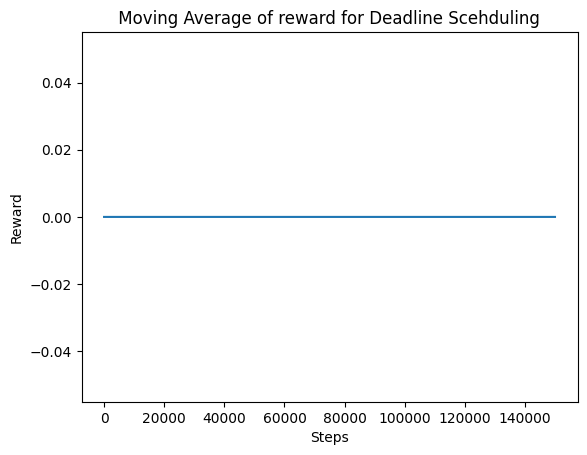

In [27]:
plt.plot(df[0].rolling(5000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title(' Moving Average of reward for Deadline Scehduling ')


Text(0.5, 1.0, ' Moving Average of number of arms activated for Deadline Scehduling ')

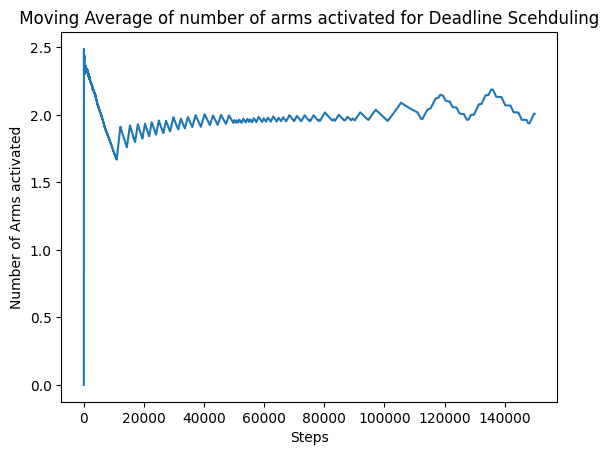

In [35]:
df=pd.DataFrame()
df['action_sums']=action_sums
plt.plot(df['action_sums'].rolling(100000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Number of Arms activated')
plt.title(' Moving Average of number of arms activated for Deadline Scehduling ')


In [29]:
current_state[0]

array([0., 0.], dtype=float32)

In [30]:
#using learnt indices
current_state=[newArrival(state_space) for _ in range(N)]
# actual_whittle_indexes=[-0.9,-0.73,-0.5,-0.26,-0.01]
reward_sums_alt_index=[]
alternative_indexes=[0 for _ in range(N)]
for i in range(1,10001):
  reward_sum_alt_index=0
  reward_sum_whittle_index=0
  for index in arm_indexes:
    temp=dqn_solver.model.Qpolicy.predict(np.array([current_state[index]]).reshape(1,1,2),verbose=0)
    alternative_indexes[index]=temp[0][0][1]-temp[0][0][0]
  indices_to_pull = sorted(range(len(alternative_indexes)), key = lambda j: alternative_indexes[j])[-M:]
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],1,state_space,newArrival_state_space,processing_cost=0.8)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
    else:
      x=step(current_state[index],0,state_space,newArrival_state_space,processing_cost=0.8)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
  reward_sums_alt_index.append(reward_sum_alt_index)
  clear_output()

In [31]:
len(reward_sums_alt_index)

10000

In [32]:
whittle_index_arms=[0 for _ in range(N)]
reward_sums_whittle_index=[]
current_state=[newArrival(state_space) for _ in range(N)]

for i in range(1,10001):
  reward_sum_whittle_index=0
  for index in arm_indexes:
    if current_state[index][1]==0:
      whittle_index_arms[index]=0
    elif ((current_state[index][1]>=1) and (current_state[index][1]<=current_state[index][0]-1)):
      whittle_index_arms[index]=1-processing_cost
    else:
      whittle_index_arms[index]=0.2*(current_state[index][1]-current_state[index][0]+1)**2-0.2*(current_state[index][1]-current_state[index][0])**2+1-processing_cost
  #print(whittle_index_arms)
  indices_to_pull = sorted(range(len(whittle_index_arms)), key = lambda j: whittle_index_arms[j])[-M:]
  # print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],1,state_space,newArrival_state_space,processing_cost=0.8)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
    else:
      x=step(current_state[index],0,state_space,newArrival_state_space,processing_cost=0.8)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
  reward_sums_whittle_index.append(reward_sum_whittle_index)


Text(0.5, 1.0, ' Moving Average of reward for Deadline Scheduling ')

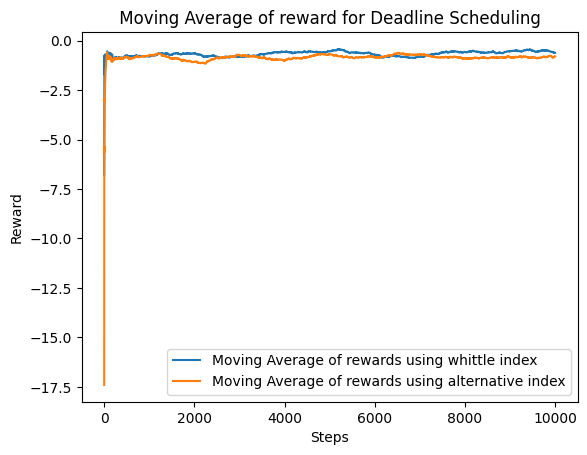

In [33]:
df_rewards=pd.DataFrame()
df_rewards['reward_whittle']=reward_sums_whittle_index
df_rewards['reward_alternate']=reward_sums_alt_index

plt.plot(df_rewards['reward_whittle'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using whittle index')
plt.plot(df_rewards['reward_alternate'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title(' Moving Average of reward for Deadline Scheduling ')